## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Author </h1>

Билинский Норгей, гр. 932328

### Задание 1. Генеративные модели нейронных сетей

Цель работы: Получить навыки создания генеративно-состязательных нейронных и аугментации данных.

Задачи:

1. Выбрать набор данных подходящие для классификации изображений (3+ класса, цветные).

2. Реализовать генеративно-состязательную нейронную сеть (conditional Gan) , для генерации изображений в соответствие с классом.

3. Обучить модель, оценить качество обучения, вывести графики функции потерь.

4. Показать результаты генерации в соответствие с классом и сгенерировать новые данные (сохранить результаты).

## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Importing libraries </h1>

In [1]:
!pip install opendatasets


In [44]:
import gc
import os
import random
import shutil
from pathlib import Path
from PIL import Image

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import opendatasets as od
import pandas as pd
import tensorflow as tf
from keras.layers import (
    BatchNormalization,
    Conv2D,
    Conv2DTranspose,
    Dense,
    Dropout,
    Embedding,
    Flatten,
    Input,
    LeakyReLU,
    Reshape,
    concatenate,
)
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    load_img,
)


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Checking the GPU environment </h1>

In [ ]:
!nvidia-smi


Wed Jan 29 11:34:16 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Data download </h1>

In [3]:
dataset_path = Path('stanford-dogs-dataset')
if not dataset_path.is_file():
    od.download('https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset')


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: norgey
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset


100%|██████████| 750M/750M [00:17<00:00, 43.8MB/s]


In [4]:
data_path = Path('stanford-dogs-dataset/images/Images')
train_path = Path('stanford-dogs-dataset/Train')

if not data_path.exists():
    print(f"Error: The specified data path '{data_path}' does not exist.")
    exit()

folders = [f for f in data_path.iterdir() if f.is_dir()]
folder_counts = []
for folder in folders:
    image_count = len(list(folder.glob('*')))
    folder_counts.append((folder, image_count))

# Сортируем папки по убыванию количества картинок
folder_counts.sort(key=lambda item: item[1], reverse=True)
# Выбираем 4 папки с наибольшим количеством картинок
top_4_folders = folder_counts[:4]

print("Top 4 folders with most images:")
for folder, count in top_4_folders:
    print(f"{folder.name}: {count}")

# Создаем папку Train, если она не существует
train_path.mkdir(exist_ok=True)
# Копируем 4 папки в train_path и переименовываем их
for folder, _ in top_4_folders:
    new_folder_name = folder.name.split('-', 1)[1] if '-' in folder.name else folder.name
    new_folder_path = train_path / new_folder_name
    shutil.copytree(folder, new_folder_path)
    print(f"Copied and renamed '{folder.name}' to '{new_folder_name}' in '{train_path}'")


Top 4 folders with most images:
n02085936-Maltese_dog: 252
n02088094-Afghan_hound: 239
n02092002-Scottish_deerhound: 232
n02112018-Pomeranian: 219
Copied and renamed 'n02085936-Maltese_dog' to 'Maltese_dog' in 'stanford-dogs-dataset/Train'
Copied and renamed 'n02088094-Afghan_hound' to 'Afghan_hound' in 'stanford-dogs-dataset/Train'
Copied and renamed 'n02092002-Scottish_deerhound' to 'Scottish_deerhound' in 'stanford-dogs-dataset/Train'
Copied and renamed 'n02112018-Pomeranian' to 'Pomeranian' in 'stanford-dogs-dataset/Train'


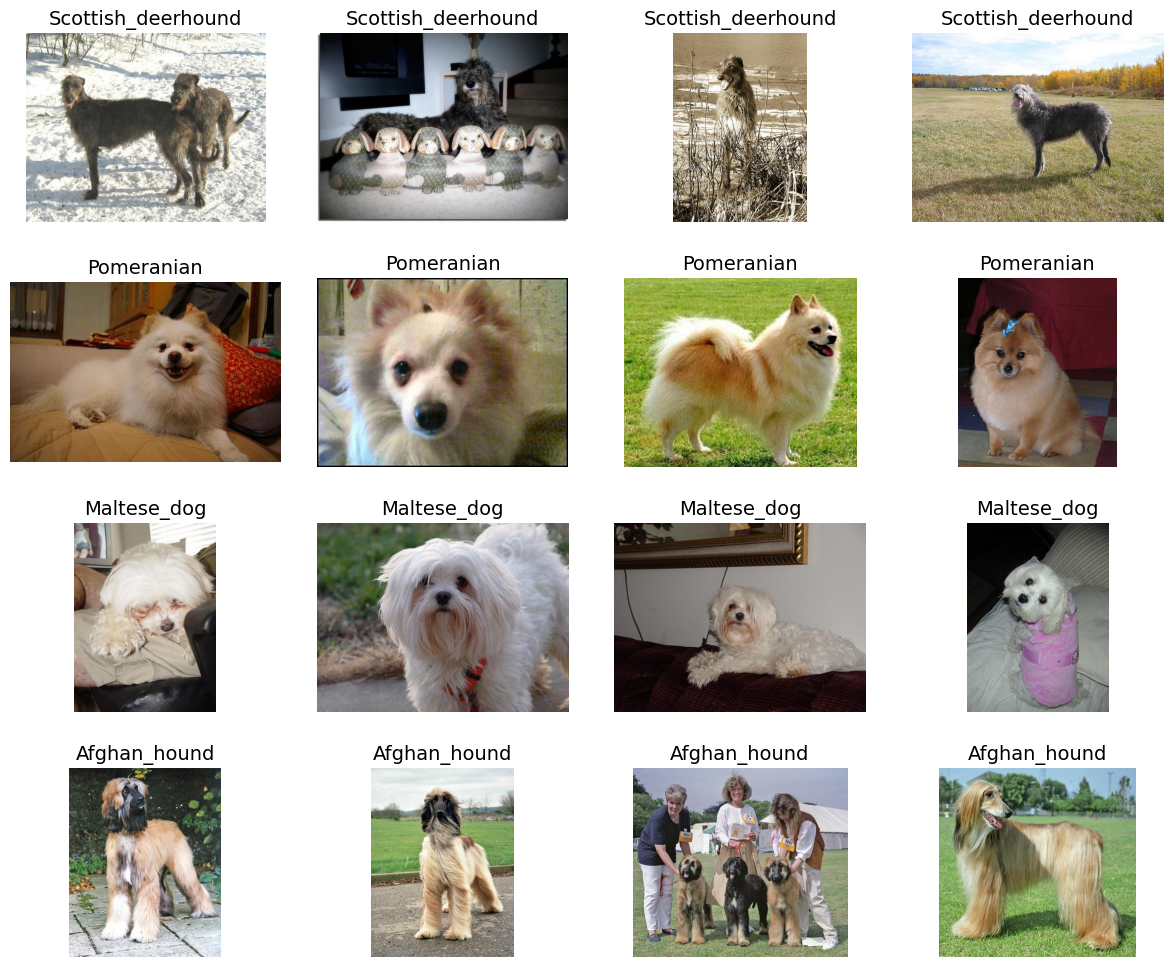

In [5]:
fig, axes = plt.subplots(4, 4, figsize=(15, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.1)

axes = axes.flat #Делаем одномерный массив для итерации
for i, folder in enumerate(train_path.iterdir()):
    if not folder.is_dir():
        continue  # Пропускаем, если это не папка

    images = list(folder.glob('*.*'))
    images = [img for img in images if img.suffix.lower() in ['.jpg', '.jpeg', '.png']]

    if len(images) < 4:
      print(f"Warning: Folder '{folder.name}' has less than 5 images.")
      continue

    random_images = random.sample(images, 4)

    for j, img_path in enumerate(random_images):
      ax_index = i * 4 + j #высчитываем индекс для оси
      ax = axes[ax_index]
      img = Image.open(img_path)
      ax.imshow(img)
      ax.axis('off')
      ax.set_title(f"{folder.name}", fontsize = 14)

for ax in axes[len(list(train_path.iterdir()))*4:]:
    ax.remove()
plt.show()


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Data preparation </h1>

In [6]:
IMG_HEIGHT = 32
IMG_WIDTH = 32
NUM_CLASSES = len([f for f in train_path.iterdir() if f.is_dir()])

# Функция для загрузки и подготовки изображений
def preprocess_image(image_path):
    # Загрузка изображения и изменение размера
    image = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    # Преобразование изображения в массив numpy
    image = img_to_array(image)
    # Нормализация в диапазон от -1 до +1
    image = (image.astype(np.float32) - 127.5) / 127.5
    return image

# Функция для аугментации данных
def augment_image(image):
    # Отражение по горизонтали (случайно)
    if random.random() > 0.5:
        image = np.fliplr(image)

    # Изменение освещения (случайное изменение яркости)
    brightness_factor = random.uniform(0.9, 1.1)
    image = np.clip(image * brightness_factor, -1, 1)  # Учитываем новый диапазон

    # Добавление шума
    noise = np.random.normal(0, 0.01, image.shape)
    image = np.clip(image + noise, -1, 1)  # Учитываем новый диапазон

    return image

# Функция для загрузки и подготовки данных
def load_data(path, augment=False):
    images = []
    labels = []

    for class_idx, class_folder in enumerate(path.glob('*')):
        if class_folder.is_dir():
            image_files = list(class_folder.glob('*.jpg')) + list(class_folder.glob('*.png'))

            for img_path in image_files:
                image = preprocess_image(img_path)

                if augment:
                    image = augment_image(image)

                images.append(image)
                labels.append(class_idx)  # Целочисленные метки 0,1,2,3

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

train_images, train_labels = load_data(train_path, augment=True)

print('train_images.shape:', train_images.shape)
print('Уникальные метки классов:', np.unique(train_labels))


train_images.shape: (942, 32, 32, 3)
Уникальные метки классов: [0 1 2 3]


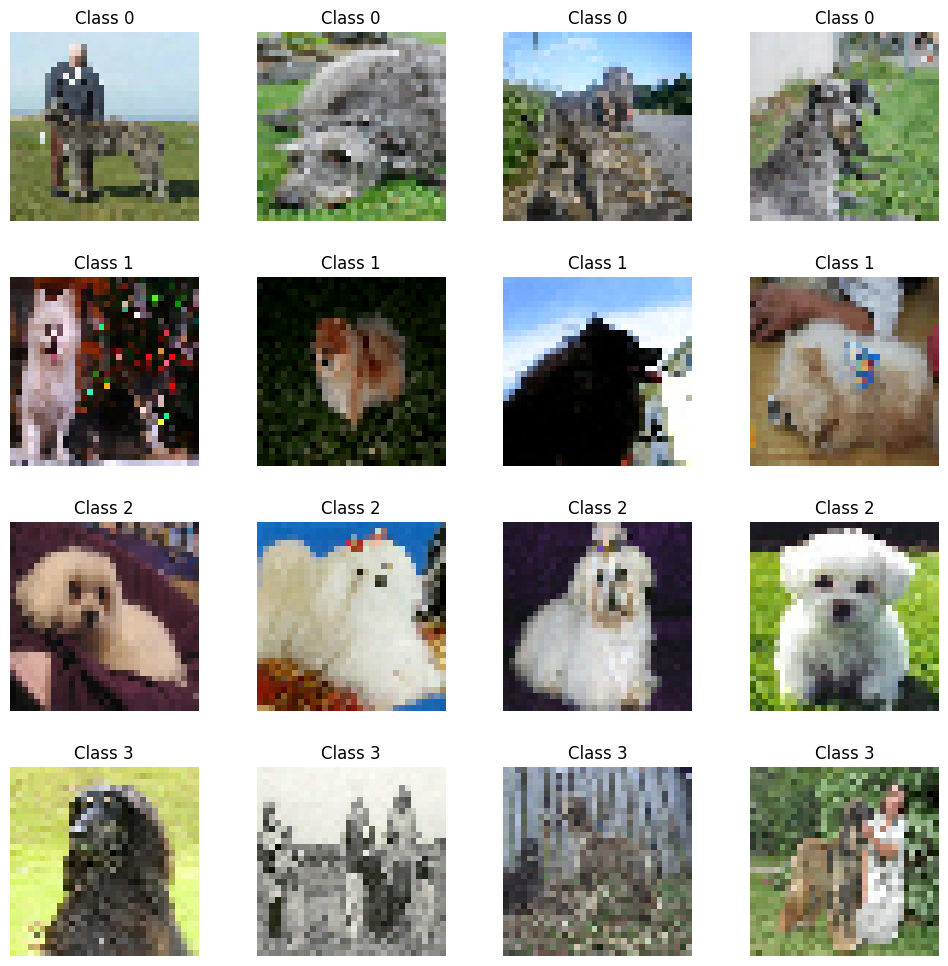

In [9]:
def display_images(images, labels, num_classes=4, samples_per_class=4):
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(12, 12))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    # Для каждого класса
    for class_idx in range(num_classes):
        # Находим индексы изображений, принадлежащих текущему классу
        class_indices = np.where(labels == class_idx)[0]

        # Если изображений для класса недостаточно, пропускаем
        if len(class_indices) < samples_per_class:
            print(f"Недостаточно изображений для класса {class_idx}. Пропускаем.")
            continue

        # Выбираем случайные изображения для отображения
        selected_indices = np.random.choice(class_indices, samples_per_class, replace=False)

        # Отображаем изображения
        for j, img_idx in enumerate(selected_indices):
            ax = axes[class_idx, j]
            # Преобразуем значения пикселей из [-1, 1] в [0, 1]
            image = (images[img_idx] + 1) / 2.0
            ax.imshow(image)  # Отображаем изображение
            ax.axis('off')  # Убираем оси
            ax.set_title(f"Class {class_idx}")  # Подпись с классом

    plt.show()

# Вызываем функцию для отображения изображений
display_images(train_images, train_labels, num_classes=4, samples_per_class=4)


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Build GAN and training</h1>

### Ошибки генератора (G) и дискриминатора (D)

Ошибки рассчитываются на основе логарифмической бинарной кросс-энтропии, которая измеряет, насколько хорошо каждый из них справляется со своей задачей.

### Ошибка дискриминатора (D Loss)

Дискриминатор пытается различить:
- **Реальные изображения**: Минимизирует ошибку при предсказании, что реальные изображения являются "настоящими".
- **Сгенерированные изображения**: Минимизирует ошибку при предсказании, что сгенерированные изображения являются "фейковыми".

Формула:

$$
\text{D Loss} = - \mathbb{E}[\log(D(x))] - \mathbb{E}[\log(1 - D(G(z)))]
$$

где:
- \( D(x) \) — вероятность, предсказанная дискриминатором для реальных изображений.
- \( D(G(z)) \) — вероятность для сгенерированных изображений.

---

### Ошибка генератора (G Loss)

Генератор пытается "обмануть" дискриминатор, чтобы изображения, которые он генерирует, были классифицированы как "настоящие".

Формула:

$$
\text{G Loss} = - \mathbb{E}[\log(D(G(z)))]
$$

где:
- \( D(G(z)) \) — вероятность, предсказанная дискриминатором для сгенерированных изображений.

---

### Идеальные значения ошибок

- **Дискриминатор**: В идеале, дискриминатор достигает точки, где он больше не может отличить настоящие изображения от фейковых. Это означает, что его ошибка стабилизируется около
$$
(\log(2) \approx 0.693),
$$
что соответствует случайному угадыванию.
- **Генератор**: Генератор будет стремиться к минимизации своей ошибки. В случае равной силы \( G \) и \( D \), ошибка генератора также стабилизируется около
$$
(\log(2) \approx 0.693)
$$

---

Таким образом, в ходе тренировки важно следить за соотношением этих ошибок, чтобы избежать ситуаций, когда одна модель доминирует над другой, что приводит к некачественным результатам.


In [8]:
def build_discriminator():
    """
    Создает модель дискриминатора для Conditional GAN.
    Принимает на вход изображение и метку класса, возвращает вероятность подлинности.
    """
    # Входные слои
    img_input = Input(shape=IMG_SHAPE)            # Изображение 32x32x3
    label_input = Input(shape=(1,))               # Метка класса (целое число)

    # Обработка метки класса:
    # 1. Преобразование в вектор с помощью Embedding
    # 2. Проецирование в пространство изображения
    label_embedding = Embedding(NUM_CLASSES, np.prod(IMG_SHAPE))(label_input)
    label_embedding = Flatten()(label_embedding)  # Преобразуем в плоский вектор
    label_embedding = Reshape(IMG_SHAPE)(label_embedding)  # Приводим к форме изображения

    # Объединение изображения и метки класса
    combined = concatenate([img_input, label_embedding])

    # Сверточные слои с уменьшением размерности (downsampling)
    x = Conv2D(32, kernel_size=3, strides=2, padding='same')(combined)
    x = LeakyReLU(alpha=0.2)(x)  # LeakyReLU лучше подходит для дискриминатора
    x = Dropout(0.3)(x)          # Регуляризация

    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    # Выходной слой
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)  # Вероятность подлинности [0, 1]

    return Model([img_input, label_input], x, name='Discriminator')

def build_generator():
    """
    Создает модель генератора для Conditional GAN.
    Принимает на вход шум и метку класса, возвращает сгенерированное изображение.
    """
    # Входные слои
    noise_input = Input(shape=(LATENT_DIM,))  # Шумовой вектор
    label_input = Input(shape=(1,))           # Метка класса (целое число)

    # Обработка метки класса:
    # 1. Преобразование в вектор с помощью Embedding
    # 2. Проецирование в пространство шума
    label_embedding = Embedding(NUM_CLASSES, LATENT_DIM)(label_input)
    label_embedding = Flatten()(label_embedding)  # Преобразуем в плоский вектор

    # Объединение шума и метки класса
    combined = concatenate([noise_input, label_embedding])

    # Блоки апсемплинга с Conv2DTranspose
    x = Dense(128 * 8 * 8)(combined)  # Проецируем в пространство для сверток
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((8, 8, 128))(x)       # Форма 8x8x128

    # Увеличение разрешения до 16x16
    x = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)       # Стабилизирует обучение
    x = LeakyReLU(alpha=0.2)(x)

    # Увеличение разрешения до 32x32
    x = Conv2DTranspose(32, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Финишный слой - генерация изображения
    img_output = Conv2DTranspose(
        3, kernel_size=3, strides=1, padding='same',
        activation='tanh'  # tanh дает выход в диапазоне [-1, 1]
    )(x)

    return Model([noise_input, label_input], img_output, name='Generator')


In [42]:
EPOCHS = 1_000
BATCH_SIZE = 64
LATENT_DIM = 256
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)  # Форма изображений
NUM_CLASSES = len([f for f in train_path.iterdir() if f.is_dir()])

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

def build_and_compile_models():
    # 1. Дискриминатор
    discriminator = build_discriminator()
    discriminator.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
        metrics=['accuracy']
    )

    # 2. Генератор
    generator = build_generator()

    # 3. GAN (замороженный дискриминатор)
    discriminator.trainable = False

    # Шум и метка как вход для генератора
    noise = Input(shape=(LATENT_DIM,))
    label = Input(shape=(1,))  # Метка как целое число

    # Генерируем изображение
    img = generator([noise, label])

    # Проверяем подлинность
    validity = discriminator([img, label])

    # Полная модель GAN
    gan = Model([noise, label], validity)
    gan.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.0002, beta_1=0.5)
    )

    return generator, discriminator, gan

generator, discriminator, gan = build_and_compile_models()

history = {
    'd_loss': [],
    'g_loss': [],
}

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # Перемешиваем данные
    idx = np.random.permutation(len(train_images))
    real_images = train_images[idx]
    labels = train_labels[idx]  # Используем целочисленные метки

    # Для подсчета средних значений за эпоху
    epoch_d_loss = []
    epoch_g_loss = []

    for batch_i in range(0, len(real_images), BATCH_SIZE):
        # Текущий батч
        batch_size = min(BATCH_SIZE, len(real_images) - batch_i)
        batch_images = real_images[batch_i:batch_i+batch_size]
        batch_labels = labels[batch_i:batch_i+batch_size].reshape(-1, 1)  # Форма (batch_size, 1)

        # ================================================
        #  Обучаем дискриминатор
        # ================================================

        # Генерируем фейковые изображения
        noise = np.random.normal(0, 1, (batch_size, LATENT_DIM))
        gen_images = generator.predict([noise, batch_labels], verbose=0)

        # Метки для реальных и фейковых изображений
        real_y = np.ones((batch_size, 1)) * 0.9  # Label smoothing
        fake_y = np.zeros((batch_size, 1))

        # Обучаем на реальных изображениях
        d_loss_real = discriminator.train_on_batch(
            [batch_images, batch_labels],
            real_y
        )

        # Обучаем на фейковых изображениях
        d_loss_fake = discriminator.train_on_batch(
            [gen_images, batch_labels],
            fake_y
        )

        # Средний лосс дискриминатора
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ================================================
        #  Обучаем генератор
        # ================================================

        # Новый шум и метки
        noise = np.random.normal(0, 1, (batch_size, LATENT_DIM))
        valid_y = np.ones((batch_size, 1))  # "Обманываем" дискриминатор

        # Обучаем генератор через GAN
        g_loss = gan.train_on_batch(
            [noise, batch_labels],
            valid_y
        )

        # Сохраняем метрики для текущего батча
        epoch_d_loss.append(d_loss[0])
        epoch_g_loss.append(g_loss)

        # Очистка памяти
        del batch_images, batch_labels, noise, gen_images, real_y, fake_y, valid_y
        gc.collect()

    avg_d_loss = np.mean(epoch_d_loss)
    avg_g_loss = np.mean(epoch_g_loss)

    history['d_loss'].append(avg_d_loss)
    history['g_loss'].append(avg_g_loss)

    if (epoch+1) % 250 == 0:
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"Discriminator Loss: {avg_d_loss:.2f}")
        print(f"Generator Loss: {avg_g_loss:.2f}")



Epoch 0 Summary:
Discriminator Loss: 0.78
Generator Loss: 0.41

Epoch 250 Summary:
Discriminator Loss: 0.59
Generator Loss: 1.79

Epoch 500 Summary:
Discriminator Loss: 0.68
Generator Loss: 1.23

Epoch 750 Summary:
Discriminator Loss: 0.63
Generator Loss: 1.21

Epoch 1000 Summary:
Discriminator Loss: 0.85
Generator Loss: 0.93


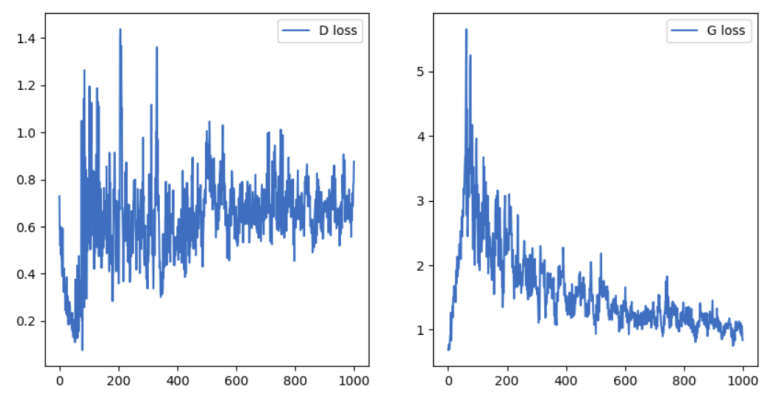

In [39]:
d_losses = history['d_loss']
g_losses = history['g_loss']

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(d_losses, label='D loss')
plt.title("Дискриминатор: Потери")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(g_losses, label='G loss')
plt.title("Генератор: Потери")
plt.legend()

plt.show()


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Generation of new images from GAN </h1>

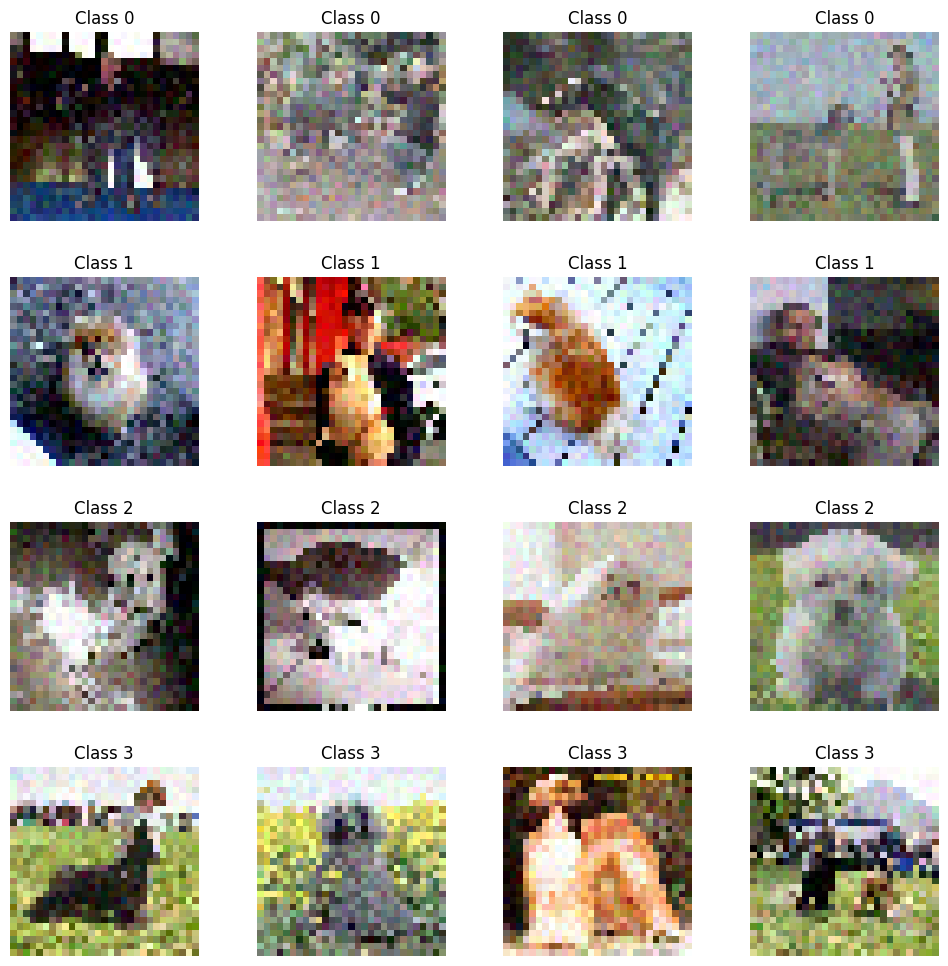

In [28]:
IMAGES_PER_CLASS = 4
NUM_CLASSES = len([f for f in train_path.iterdir() if f.is_dir()])
LATENT_DIM = 256

# Генерация шума и меток классов
noise = np.random.normal(0, 1, (NUM_CLASSES * IMAGES_PER_CLASS, LATENT_DIM))
labels = np.repeat(np.arange(NUM_CLASSES), IMAGES_PER_CLASS)
labels = np.expand_dims(labels, axis=-1)  # Преобразуем в форму (N, 1)

# Генерация изображений с помощью обученного генератора
generated_images = generator.predict([noise, labels], verbose=0)

# Преобразование изображений из [-1, 1] в [0, 1] для корректного отображения
generated_images = (generated_images + 1) / 2.0

fig, axes = plt.subplots(NUM_CLASSES, IMAGES_PER_CLASS, figsize=(IMAGES_PER_CLASS * 2, NUM_CLASSES * 2))

for i in range(NUM_CLASSES):
    for j in range(IMAGES_PER_CLASS):
        ax = axes[i, j]
        img_idx = i * IMAGES_PER_CLASS + j
        ax.imshow(generated_images[img_idx])
        ax.axis('off')
        ax.set_title(f"Class {i}", fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
PATH_SAVE = '/content/drive/My Drive/Университет/Глубокое обучение/Generation images'
IMAGES_PER_CLASS = 50
LATENT_DIM = 256

# Генерация и сохранение изображений
for class_idx in range(NUM_CLASSES):
    # Создание папки для каждого класса, если она не существует
    class_path = os.path.join(PATH_SAVE, f'class_{class_idx}')
    os.makedirs(class_path, exist_ok=True)

    # Генерация шума и меток для текущего класса
    noise = np.random.normal(0, 1, (IMAGES_PER_CLASS, LATENT_DIM))
    labels = np.full((IMAGES_PER_CLASS, 1), class_idx)

    # Генерация изображений
    generated_images = generator.predict([noise, labels], verbose=0)

    # Преобразование изображений из [-1, 1] в [0, 1]
    generated_images = (generated_images + 1) / 2.0

    # Сохранение каждого изображения в папку класса
    for img_idx in range(IMAGES_PER_CLASS):
      image = generated_images[img_idx]
      image = (image * 255).astype(np.uint8) # Приведение типов
      image = keras.utils.array_to_img(image) # Преобразование из массива в объект изображения
      image_name = f'generated_image_{img_idx}.png'
      image_path = os.path.join(class_path, image_name)
      image.save(image_path)
